# Inversion using artificial neural network (ANN)
This notebook walk you through the current implementation of ANN inversion in emagpy.

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import time
import sys
sys.path.append('../src')
from emagpy import Problem
datadir = '../src/examples/'

Removing 1 NaN from survey
Deleted 3/120 measurements


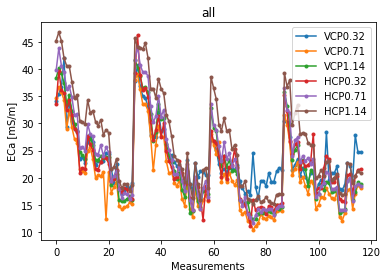

In [12]:
k = Problem()
k.createSurvey(datadir + 'cover-crop/coverCrop.csv')
k.filterRange(vmax=50)
k.show()

## Inversion with ANN
The current implementation in EMagPy uses the tensorflow package (`pip install tensorflow`). It proceeds as follow:
- Given a number of samples and bounds for each parameters, `Problem.buildANN()` create uniform distribution of the paramters within the bounds and use them to generate corresponding ECa values with the chosen forward model. Noise can be added to the synthetic ECa values.
- The ANN is build and trained on these synthetic data
- The trained ANN is used for predicting the parameters values given the observed ECa (= inversion)
- Predicted values falling out of the bounds are inverted again using the `L-BFGS-B` solver

  0%|          | 0/117 [00:00<?, ?it/s]

Survey 1/1


100%|██████████| 117/117 [00:12<00:00,  9.26it/s]



Building and training ANN network
bounds = [(12.661, 41.639199999999995), (12.661, 41.639199999999995), (12.661, 41.639199999999995)]

....................................................................................................
..............................................
ANN: Testing set Mean Abs Error:  3.60
Finish training the network (5.29s)
Survey 1/1
.


Text(0.5, 1.0, '(b) ANN (n=500, noise=5%)')

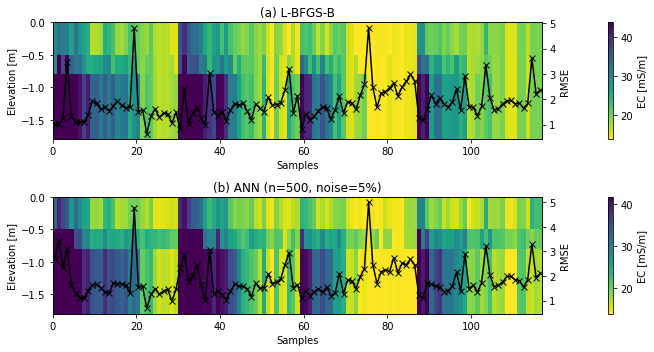

In [13]:
k.setInit(depths0=[0.5, 0.8])
fig, axs = plt.subplots(2, 1, figsize=(10,5))

# L-BFGS-B
ax = axs[0]
k.invert(njobs=-1)
k.showResults(rmse=True, ax=ax)
ax.set_title('(a) L-BFGS-B')

# ANN
ax = axs[1]
nsample = 500
noise = 0.05 # 5% noise
k.invert(method='ANN', nsample=nsample, noise=noise)
k.showResults(rmse=True, ax=ax)
ax.set_title('(b) ANN (n={:d}, noise={:.0f}%)'.format(nsample, noise*100))

  0%|          | 0/117 [00:00<?, ?it/s]

Removing 1 NaN from survey
Deleted 3/120 measurements
Survey 1/1


100%|██████████| 117/117 [00:09<00:00, 12.62it/s]



Building and training ANN network

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
ANN: Testing set Mean Abs Error:  1.53
Finish training the network (7.14s)
Survey 1/1



Text(0.5, 1.0, '(b) ANN (n=100, noise=2%)')

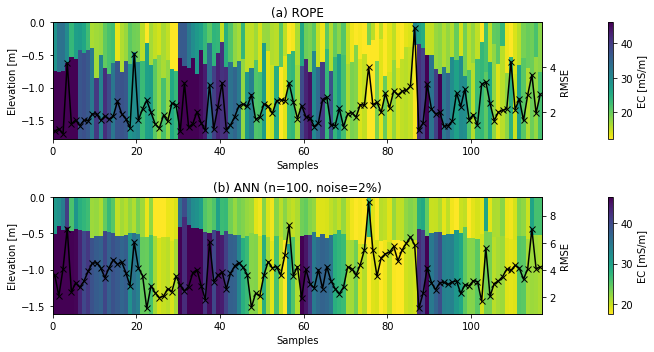

In [16]:
# with non fixed depths
k = Problem()
k.createSurvey(datadir + 'cover-crop/coverCrop.csv')
k.filterRange(vmax=50)
k.setInit(depths0=[0.7], fixedDepths=[False])
fig, axs = plt.subplots(2, 1, figsize=(10,5))

# ROPE
ax = axs[0]
k.invert(method='ROPE', njobs=-1)
k.showResults(rmse=True, ax=ax)
ax.set_title('(a) ROPE')

# ANN
ax = axs[1]
nsample = 100
noise = 0.02 # 2% noise
k.invert(method='ANN', nsample=nsample, noise=noise)
k.showResults(rmse=True, ax=ax)
ax.set_title('(b) ANN (n={:d}, noise={:.0f}%)'.format(nsample, noise*100))

In [7]:
# impact of sample size and noise
out = []
for i, nsample in enumerate([100, 1000]):
    for j, noise in enumerate([0.0, 0.02, 0.05]):
        for l in range(5): # 5 repetitions
            t0 = time.time()
            k.invert(method='ANN', nsample=nsample, noise=noise)
            elapsed = time.time() - t0
            rmse = k.getRMSE()['all'].values[0]
            out.append({'nsample': nsample,
                         'noise': noise,
                         'elapsed': elapsed,
                         'annReplaced': k.annReplaced,
                         'RMSE': rmse})

bounds = [(0.2, 0.8999999999999999), (2.0, 100.0), (2.0, 100.0)]
Building and training ANN network

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
ANN: Testing set Mean Abs Error:  1.58
Finish training the network (6.80s)
Survey 1/1
.
bounds = [(0.2, 0.8999999999999999), (2.0, 100.0), (2.0, 100.0)]
Building and training ANN network

....................................................................................................
....................................................................................................
.....

In [10]:
pd.DataFrame(out).groupby(['nsample','noise']).mean()

elapsed  annReplaced      RMSE
nsample noise                                  
100     0.00    7.249628          2.2  4.675226
        0.02    7.664393          1.0  3.455503
        0.05    8.572983          0.0  2.268650
1000    0.00   30.396416         15.8  7.378945
        0.02   23.519777          0.0  5.153162
        0.05   24.798541          0.0  2.756808

### Observations
- The larger the sample, the more time it takes to train (logic)
- Noisier data does not take more time to train
- Larger sample size decreases the overall RMSE
- Larger noise reduces the number of outlier produced by the ANN

Removing 1 NaN from survey
Deleted 3/120 measurements
Building and training ANN network

....................................................................................................
....................................................................................................
....................................................................................................
....................................
ANN: Testing set Mean Abs Error:  2.23
Finish training the network (5.45s)
Survey 1/1



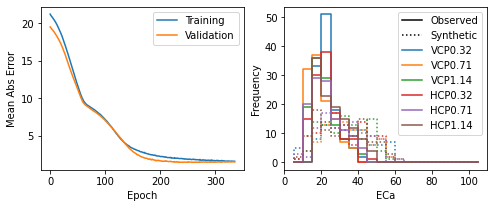

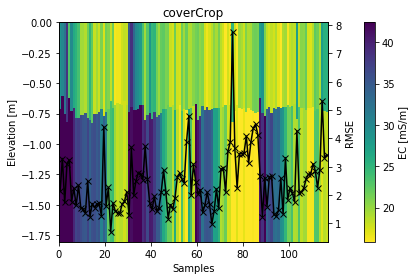

In [17]:
k = Problem()
k.createSurvey(datadir + 'cover-crop/coverCrop.csv')
k.filterRange(vmax=50)
k.setInit(depths0=[0.7], fixedDepths=[False])
bnds = [(0.2, 1), (2, 60), (2, 60)] # choose bounds that matches the observed ECa values
k.invert(method='ANN', nsample=100, noise=0.05, annplot=True, bnds=bnds)
k.showResults(rmse=True)

## Notes
- good to have a look at the diagnostic plots (`annplot=True`) to well the ANN is trained (it should decrease too fast) but also if the distribution of the synthetic parameters (dashed) is similar to the observed ECa values (plain)